# Overview

In this notebook, we demonstrate how we preprocess our HRTEM image data to create datasets that can be used to train data-driven algorithms. In total, our preprocessing and dataset creation consists of the following steps:

[1. Grab all of the images with specified metadata parameters and their corresponding labels](#Pull-images) <br>
[2. Remove outlier pixel values from x-rays](#Pull-images) <br>
[3. Remove session-dependent uneven ilumination via a Bezier-basis, flat-field correction](#Remove-background-and-standardize) <br>
[4. Standardize the pixel values per image](#Remove-background-and-standardize) <br>
[5. Divide up each image into 512x512 pixel patches](#Create-patches) <br>
[6. Remove patches that are mostly background to improve class-balance](#Create-patches) <br>

As an example, we will create the 5nm Ag nanoparticle dataset, used in Figure 3c/d of "Developing Generalizable Neural Networks for HRTEM Analysis". To quickly run the code with your own subset parameters, click [here](#Dataset-creation-(quick))

# Import packages and define routines

In [1]:
import pandas as pd
import numpy as np
from ncempy.io import dm
import h5py
from glob import glob
import os
from routines import * #Import all routines from the file routines.py
import random
from scipy.special import comb
from skimage import transform

# For visualization within the notebook
import matplotlib.pyplot as plt

In [2]:
#Import the spreadsheet of filenames and image attributes
spreadsheet_file = 'Dataset_metadata.csv'
file_list = pd.read_csv(spreadsheet_file)

In [3]:
# This is a routine that creates a pandas DataFrame with the data that meets the subset requirements
def subset_datafile(dataframe,subset_reqs):
    # dataframe is the pandas DataFrame with all of the metadata
    # subset_reqs is a list of tuples with the metadata requirements for the subset
    # The tuples either have 2 inputs (metadata, value) or 3 inputs (metadata, value, margin), and value can either be a string or quantitative number
    subset = dataframe
    subset_reqs_list = subset_reqs.copy()
    while len(subset_reqs_list)>0:
        listing = subset_reqs_list.pop()
        if len(listing)==2:
            heading = listing[0]
            value = listing[1]
            threshold = 1e-5
        else:
            heading = listing[0]
            value = listing[1]
            threshold = listing[2]
        if isinstance(value, str):
            subset = subset[subset[heading].isin([value])]
        else:
            diff = subset[heading]-value
            subset = subset[diff.abs()<threshold]
    return subset

# This function takes the subset DataFrame and pulls the associated dm3 files and their corresponding labels. It returns two lists of images and their corresponding labels
def pull_images(subset,local_loc = 'hrtem_files',label_ending='_label.png',threshold=3000):
    # subset is the pandas DataFrame with the files you wish to pull
    # local_loc is a string with the location of all of the downloaded file folders
    # label_ending is a string that distinguishes a label file from an image file
    # threshold determines the pixel value (median + threshold) over which a pixel is considered an outlier during x-ray removal
    images = []
    labels = []
    for i in range(subset.shape[0]): #For each file in the dataframe
        file = subset.iloc[i] #Get the i-th file
        
        file_path = os.path.join(local_loc,file['Folder'],file['File name'])
        label_name = file['File name'].split('.')[0]+label_ending
        label_path = os.path.join(local_loc,file['Folder'],'Labels',label_name)
        
        img = dm.dmReader(file_path)['data']
        print('File: '+ file['File name'])
        img = xray_correct_threshold(img,threshold) #Remove spurious x-ray peaks
        images.append(img)
        
        lbl = plt.imread(label_path)
        labels.append(lbl)
    return images, labels

# This function creates a Bezier basis; adapted from code from Colin Ophus
def create_Bezier_basis(img_size,mn):
    # img_size defines pixel size of the Bezier basis
    # mn is a list that defines the number control points/segments in x and y (this dictates the number of basis functions)
    
    # Define Bezier basis
    x_coords = np.linspace(0,1,img_size)
    y_coords = np.linspace(0,1,img_size)
    [v,u] = np.meshgrid(x_coords, y_coords) # Create matricies with the index location
    
    #Bezier control points/segments
    total_basis_num = (mn[0]+1)*(mn[1]+1)
    basis = np.zeros((img_size,img_size,total_basis_num))
    for i in range(mn[0]+1):
        for j in range(mn[1]+1):
            Ni = comb(mn[0],i)*(u**i)*(1-u)**(mn[0]-i)
            Nj = comb(mn[1],j)*(v**j)*(1-v)**(mn[1]-j)
        
            idx = j + i*(mn[1]+1)
            basis[:,:,idx] = Ni*Nj
    return basis

# This function fits the given image to the Bezier basis via iterative reweighting and returns the fitted coefficients; adapted from code from Colin Ophus
def get_coeffs_iterative_reweighting(img,basis,iters=1):
    # img is the image to be fit (numpy array)
    # basis is the Bezier basis (numpy array) with size (img_size, img_size, num_basis)
    # iters is the number of reweighting iterations to do. Iters=1 is the default least-squares fitting
    weight_mat = np.ones((basis.shape[0],1))
    for i in range(iters):
        basis_rw = np.multiply(weight_mat,basis)
        img_rw = np.multiply(weight_mat,np.expand_dims(np.ravel(img),1))
        coeff= np.linalg.lstsq(basis_rw,img_rw,rcond=None)[0]
        #Update the weight matrix
        err_mat = np.power(np.expand_dims(np.ravel(img),1)-np.dot(basis,coeff),2)
        avg_err = np.mean(err_mat)
        weight_mat = np.exp(-3*err_mat/(2*avg_err))
    return coeff

# This function resizes image and basis (for memory purposes), calculates coeffs and returns a flat-field corrected image
def flatfield_corr(img,basis,scale,iters):
    # img is the image to be fit (numpy array)
    # basis is the Bezier basis (numpy array) with size (img_size, img_size, num_basis)
    # scale is the scaling factor used to make the least-squares fitting less memory-intensive. 
    # iters is the number of reweighting iterations to do. Iters=1 is the default least-squares fitting
    img_rsc = transform.rescale(img,scale)
    basis_rsc = transform.rescale(basis,scale,multichannel = True)
    coeffs = get_coeffs_iterative_reweighting(img_rsc,np.reshape(basis_rsc,(-1,basis_rsc.shape[-1])),iters)
    
    #Correct image
    bkgd = np.reshape(np.dot(np.reshape(basis,(-1,basis.shape[-1])),coeffs),(img.shape[0],img.shape[1]))
    img_corr = img/bkgd #pixelwise divide out the uneven illumination
    return img_corr

# This function removes the patches that are majority background
def remove_bkgd_patches(imgs,lbls,threshold=100):
    # imgs is a list of image patches
    # lbls is a list of (corresponding) label patches
    # threshold is the minimum number of non-background pixels needed to include a patch in the final dataset
    
    #First convert to numpy array
    lbls = np.asarray(lbls)
    imgs = np.asarray(imgs)
    #Sum up all of the non-background pixels per image
    lbled_pixels = np.sum(lbls,axis=(1,2))
    #Only take patches with more than threshold pixels of "particle"
    lbls = lbls[lbled_pixels>threshold]
    imgs = imgs[lbled_pixels>threshold]
    return imgs, lbls

def shuffle_dataset_list(img_list, label_list, seed):
    img_array = np.array(img_list)
    lbl_array = np.array(label_list)
    
    np.random.seed(seed)
    new_index = np.arange(0,img_array.shape[0],1)
    np.random.shuffle(new_index,)
    
    return img_array[new_index,:,:], lbl_array[new_index,:,:]

#Save as h5 files
def write_h5(dataset, h5_name, label):
    hf = h5py.File(h5_name, 'w')
    hf.create_dataset(label, data=dataset)
    hf.close()

# Dataset creation (quick)

The following code will create a dataset using the preprocessing steps listed above.

In [4]:
def patch_creation_FFstd(file_database, subset_req, pull_loc, lbl_ending, xray_threshold, shuffle_seed, bkgd_threshold = 400):
    # file_database is the entire DataFrame of the metadata
    # subset_req is the list of metadata attributes you wish to have in the data that you pull
    # pull_loc is the local location where the folder structure is stored (i.e. where you want to pull from)
    # lbl_ending is the string that distinguishes a label file from an image file
    # xray_threshold determines the pixel value (median + threshold) over which a pixel is considered an outlier during x-ray removal
    # shuffle_seed sets the random seed
    # bkgd_threshold is the minimum number of non-background pixels needed to include a patch in the final dataset
    
    subset = subset_datafile(file_database,subset_req)
    #Print out the files that are in this subset, makes it easy to double check we have the correct files
    display(subset)
    
    #Pull the images
    img_list, lbl_list = pull_images(subset,local_loc = pull_loc,label_ending=lbl_ending, threshold = xray_threshold)
    
    #Flatfield correction then standardize
    img_std_list = []
    bezier_basis = create_Bezier_basis(img_list[0].shape[0],[2,2])
    for img in img_list:
        img_corr = flatfield_corr(img,bezier_basis,0.25,2) # During background fitting, rescale images to a quarter of original size (so working with 1024x1024 matricies)
        img_corr = standardize(img_corr)
        img_std_list.append(img_corr)
    
    #Shuffle images
    img_shuffled, lbl_shuffled = shuffle_dataset_list(img_std_list, lbl_list, shuffle_seed)
    
    #Create patches
    img_patches, lbl_patches = create_patches(img_shuffled, lbl_shuffled)
    img_patches, lbl_patches = remove_bkgd_patches(img_patches, lbl_patches, threshold=bkgd_threshold)
    
    return img_patches, lbl_patches

So if I wanted to grab the 5nm Ag dataset taken at a specific microscope magnification:

In [5]:
subset_reqs = [('Material', 'Ag'), 
              ('Nanoparticle Size (nm)', 5),
              ('Dosage (e/A2)', 423, 20), 
              ('Pixel Scale (nm)', 0.02)]
ag_imgs, ag_lbls = patch_creation_FFstd(file_list, subset_reqs, pull_loc = 'hrtem_files', lbl_ending='_label.png', xray_threshold=1500, shuffle_seed=34522)

,File name,Date,Material,Nanoparticle Size (nm),Nanoparticle Shape,Support,Instrument,Dosage (e/A2),Pixel Scale (nm),Folder
239,20220202_Ag_UTC_330kx_2650e_0p1596s_01.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
240,20220202_Ag_UTC_330kx_2650e_0p1596s_02.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
241,20220202_Ag_UTC_330kx_2650e_0p1596s_03.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
242,20220202_Ag_UTC_330kx_2650e_0p1596s_04.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
243,20220202_Ag_UTC_330kx_2650e_0p1596s_05.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
244,20220202_Ag_UTC_330kx_2650e_0p1596s_06.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
245,20220202_Ag_UTC_330kx_2650e_0p1596s_07.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
246,20220202_Ag_UTC_330kx_2650e_0p1596s_08.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
247,20220202_Ag_UTC_330kx_2650e_0p1596s_09.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
248,20220202_Ag_UTC_330kx_2650e_0p1596s_10.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC


File: 20220202_Ag_UTC_330kx_2650e_0p1596s_01.dm3
Number of detected x-rays: 2
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_02.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_03.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_04.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_05.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_06.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_07.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_08.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_09.dm3
Number of detected x-rays: 0
Up

We can then look at some sample images from the dataset, along with the dataset size, before finally saving the dataset:

Number of patches:  430


(-0.5, 511.5, 511.5, -0.5)

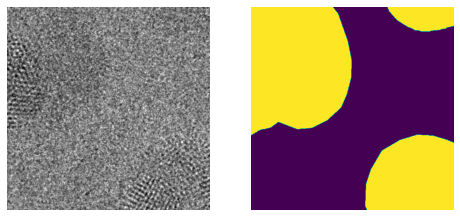

In [7]:
print('Number of patches: ', ag_imgs.shape[0])

sample_num = 15
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(ag_imgs[sample_num,:,:],cmap='gray',vmin=-4,vmax=4)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ag_lbls[sample_num,:,:])
plt.axis('off')

In [8]:
# Save dataset
write_h5(ag_imgs,'../Datasets/Ag_5nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5','images')
write_h5(ag_lbls, '../Datasets/Ag_5nm_330kx_423e_Std_UTC_FFCorr_Team05_Labels.h5', 'labels')

For more detailed explanations of each preprocessing step, see below:

# Pull images

To work with the images and labels, we need to identify which images we want to work with, and grab that data into this notebook. We first create a list of the metadata requirements for our subset of data. This list of subset requirements needs to be satisfied by all members of the subset. As detailed further in the download_data_example Jupyter notebook, the subset requirements is a list of tuples, with each tuple specifying how to sort or subset the metadata. Two-entry tuples specify the wanted metadata header and value. Three-entry tuples provide a margin for the metadata value.

Here, we're going to grab all the images of 5nm Ag nanoparticles taken at 0.02 nm/pixel scale with dosage values within the range of $423 \pm 20$ e/A^2. 

In [11]:
subset_reqs = [('Material', 'Ag'), 
              ('Nanoparticle Size (nm)', 5),
              ('Dosage (e/A2)', 423, 20), 
              ('Pixel Scale (nm)', 0.02)]
subset = subset_datafile(file_list,subset_reqs)
#Print out the files that are in this subset, makes it easy to double check we have the correct files
display(subset)

,File name,Date,Material,Nanoparticle Size (nm),Nanoparticle Shape,Support,Instrument,Dosage (e/A2),Pixel Scale (nm),Folder
239,20220202_Ag_UTC_330kx_2650e_0p1596s_01.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
240,20220202_Ag_UTC_330kx_2650e_0p1596s_02.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
241,20220202_Ag_UTC_330kx_2650e_0p1596s_03.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
242,20220202_Ag_UTC_330kx_2650e_0p1596s_04.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
243,20220202_Ag_UTC_330kx_2650e_0p1596s_05.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
244,20220202_Ag_UTC_330kx_2650e_0p1596s_06.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
245,20220202_Ag_UTC_330kx_2650e_0p1596s_07.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
246,20220202_Ag_UTC_330kx_2650e_0p1596s_08.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
247,20220202_Ag_UTC_330kx_2650e_0p1596s_09.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC
248,20220202_Ag_UTC_330kx_2650e_0p1596s_10.dm3,02/02/22,Ag,5.0,Sphere,UT Carbon,Team05,423,0.02,2022_02_02 5nm Ag nanoparticles on UTC


From this, we can see that there are 14 images to grab. Next, we will pull these 14 images into this notebook in addition to their corresponding labels. For each image, we will identify outliers from x-rays by looking for pixel values that are above the (image median+threshold) value, and then apply a local mean filter (ignoring the outlier value). We then repeat this twice (in case the x-ray outlier values span more than one pixel). As seen below, most images have none or only a few x-rays. 

In [12]:
img_list, lbl_list = pull_images(subset,local_loc = 'hrtem_files',label_ending='_label.png', threshold = 1500)

File: 20220202_Ag_UTC_330kx_2650e_0p1596s_01.dm3
Number of detected x-rays: 2
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_02.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_03.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_04.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_05.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_06.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_07.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_08.dm3
Number of detected x-rays: 0
Updated
Number of detected x-rays: 0
File: 20220202_Ag_UTC_330kx_2650e_0p1596s_09.dm3
Number of detected x-rays: 0
Up

We now have two lists of the images and their corresponding labels. Below, we plot one of those images:

(-0.5, 4095.5, 4095.5, -0.5)

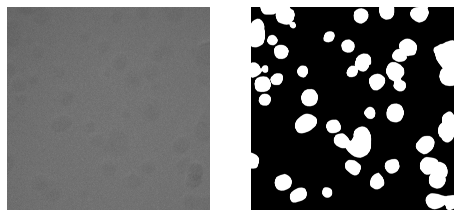

In [15]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_list[2],cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl_list[2],cmap='gray')
plt.axis('off')

# Remove background and standardize

As described in our paper, we found that removing the session-dependent uneven illumination was crucial to promote generalizability between datasets. To do so, we estimate the uneven illumination by fitting each image to a 2D Bezier basis (m=2,n=2), as shown below:

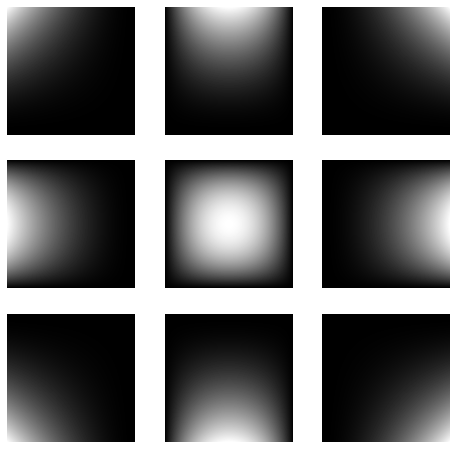

In [16]:
bezier_basis = create_Bezier_basis(img_list[0].shape[0],[2,2])
# Plotting out the Bezier functions to give a sense as to the basis set
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(bezier_basis[:,:,i],cmap='gray')
    plt.axis('off')

To account for the fact that there are areas of the image that should not contribute as much to the fitting (i.e. nanoparticle regions that inherently have a lower pixel value), we implement an interative weighted fitting where areas of high error are weighted less (the exact weighting is $e^{\frac{-3\sigma}{2<\sigma>}}$ where $\sigma$ is the error and $<\sigma>$ is the average error). Note that this choice in weighting function is a hyperparameter.

While the Bezier basis has been created at the same resolution of the image itself (in this case, 4096 x 4096 pixels), there is no real reason we need to do matrix inversion (i.e. basis set fitting) with all of the pixels. In other words, the estimated background (in the form of Bezier basis coefficients) should be similar regardless of if matrix inversion is done with high-res images or low-res images; by working with lower resolution images, we can also make the process faster. Therefore, in the code, we have a parameter "scale" which sets the rescaling factor before matrix inversion. 

Below, we show the original image, fitted background, and flat-field corrected image for a single example:

In [17]:
sample_img = img_list[2]
img_rsc = transform.rescale(sample_img,0.25) #rescale image to 0.25 of original size
basis_rsc = transform.rescale(bezier_basis,0.25,multichannel = True) #rescale Bezier basis to 0.25 of original size
coeffs = get_coeffs_iterative_reweighting(img_rsc,np.reshape(basis_rsc,(-1,basis_rsc.shape[-1])),2) # Use reweighted fitting once
    
#Correct image
bkgd = np.reshape(np.dot(np.reshape(bezier_basis,(-1,bezier_basis.shape[-1])),coeffs),(sample_img.shape[0],sample_img.shape[1]))
img_corr = sample_img/bkgd #pixelwise divide out the uneven illumination

Text(0.5, 1.0, 'Flat-field Corrected Image')

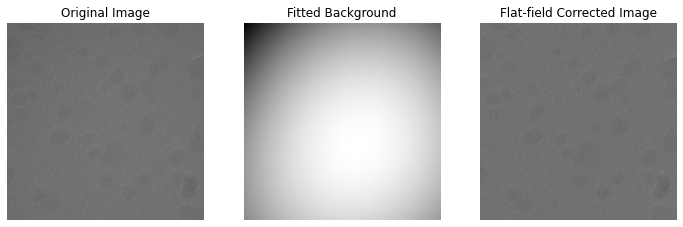

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(sample_img,cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(bkgd,cmap='gray')
plt.axis('off')
plt.title('Fitted Background')
plt.subplot(1,3,3)
plt.imshow(img_corr,cmap='gray')
plt.axis('off')
plt.title('Flat-field Corrected Image')

This whole procedure is done in the flatfield_corr routine. Finally, after removing the uneven illumination, we standardize all images (see paper for why). Below, we do this procedure for all of the images in the list:

In [20]:
#Flatfield correction then standardize
img_std_list = []
for img in img_list:
    img_corr = flatfield_corr(img,bezier_basis,0.25,2) # During background fitting, rescale images to a quarter of original size (so working with 1024x1024 matricies)
    img_corr = standardize(img_corr)
    img_std_list.append(img_corr)

Finally, we shuffle the images such that if they were grabbed sequentially, we remove any potential for sequential acquisition bias. For reproducability, we have set our random seed to 34522 for all datasets.

In [21]:
#Shuffle images
img_shuffled, lbl_shuffled = shuffle_dataset_list(img_std_list, lbl_list, 34522)

# Create patches

Finally, since directly training with the 4096x4096 pixel images would require too much GPU memory, we can lower the memory requirements by splitting the image into smaller patches. Specifically, we split it up into 512x512 patches.

In [22]:
img_patches, lbl_patches = create_patches(img_shuffled, lbl_shuffled)

However, the vast majority of these patches are purely background, leading to class balance issues during training in which the network could predict that all of the patches are background, and have fairly low error. Therefore, we remove patches that are majority background. Specifically, we check how many pixels in each patch are classified as non-background, and if this falls below some threshold value, we remove the patch. In this case, we set the threshold to 400, which corresponds to ~0.1% of the total area.

In [23]:
img_patches, lbl_patches = remove_bkgd_patches(img_patches, lbl_patches, threshold=400)

Note that the patches are kept in the same order in which they were made. This can be seen if you plot out the patches sequentially (see below). Therefore, any train-validation-test split should happen on this dataset such that patches from the same image are not as likely to be in both the training and test sets. 

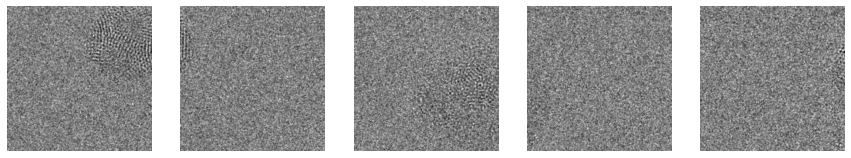

In [24]:
plt.figure(figsize=(15,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(img_patches[i],cmap='gray',vmin=-4,vmax=4)
    plt.axis('off')

# Examine and save dataset

We can now visually examine our dataset, making sure the images and labels still match up, and save it somewhere for future use.

Number of patches:  430


(-0.5, 511.5, 511.5, -0.5)

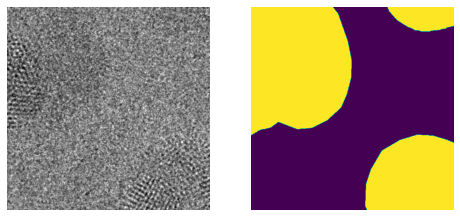

In [26]:
print('Number of patches: ', img_patches.shape[0])

sample_num = 15
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_patches[sample_num,:,:],cmap='gray',vmin=-4,vmax=4)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl_patches[sample_num,:,:])
plt.axis('off')

In [27]:
# Save dataset
write_h5(img_patches,'../Datasets/Ag_5nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5','images')
write_h5(lbl_patches, '../Datasets/Ag_5nm_330kx_423e_Std_UTC_FFCorr_Team05_Labels.h5', 'labels')